# Global mean Sea Surface Temperatures

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
from calendar import monthrange

In [3]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

In [4]:
from globales import *

>>>>>---------------------------------------------------------------------------<<<<<
    > Linux rossby 6.8.0-59-generic #61-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 11 23
    >
    > home    - /home/pvb
    > ProPath - /home/pvb/Proyectos
    > AnaPath - /home/pvb/Analisis
    > DatPath - /data/pvb
    > ArgoDta - /data/pvb/Argo
>>>>>---------------------------------------------------------------------------<<<<<


In [ ]:
import multiprocessing
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40513 instead
  warnings.warn(


In [35]:
# Define a transformation to ensure the polygon's CRS matches
# Transform the polygon to match the DataArray CRS if needed
def transform_polygon(polygon, src_crs='epsg:4326', tgt_crs='epsg:4326'):
    proj = pyproj.Transformer.from_proj(pyproj.Proj(src_crs), pyproj.Proj(tgt_crs), always_xy=True)
    return transform(lambda x, y: proj.transform(x, y), polygon)

In [36]:
def point_in_polygon(lon, lat, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

In [8]:
year1= 2003
year2= 2024

In [9]:
# Settings compute de climatoloy
yearC1='2003'
yearC2='2024'

# Inicio

In [ ]:
base_file = GlobalSU['DatPath'] + '/Satelite/MUR/NC/'
dataDir   = GlobalSU['AnaPath'] + '/SSTGlobalAnalysis/data'
imagesDir = GlobalSU['AnaPath'] + '/SSTGlobalAnalysis/images'

Process Dask Worker process (from Nanny):
2025-05-12 12:14:10,213 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-05-12 12:14:10,214 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-05-12 12:14:10,215 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-05-12 12:14:10,215 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/ocean/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/ocean/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/o

: 

In [22]:
base_file

'/data/pvb/Satelite/MUR/NC/'

In [23]:
Titulos = ['Iberian Canary Basin','Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['IBICan','LEB', 'NOR','CAN','SUD','ESA']

## Load data

In [24]:
it=3

In [25]:
titulo = Titulos[it]
titulo_short = Titulos_short[it]
print(titulo)

Demarcación marina canaria


In [26]:
files = []
for iy in range(year1,year2+1):
    for im in range(1,13):
        for id in range(1,monthrange(iy,im)[1]+1):
            files.append(base_file+"%04d%02d%02d090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"%(iy,im,id))

In [27]:
def drop_coords(ds):
    ds = ds.get(['analysed_sst'])
    return ds.reset_coords(drop=True)

DS = xr.open_mfdataset(files,combine='nested', concat_dim="time", parallel=True, combine_attrs= "drop", preprocess=drop_coords,autoclose = True, data_vars='minimal', coords="minimal", chunks={"time": 8036})

In [28]:
DS

<xarray.Dataset> Size: 42TB
Dimensions:       (time: 8036, lat: 17999, lon: 36000)
Coordinates:
  * time          (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-...
  * lat           (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon           (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 42TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>

In [73]:
# Load the data from the .txt file
demCoord = []
longDem, latiDem = [], []
with open('./data/Demarcacion'+titulo_short+'.txt', 'r') as f:
    for line in f:
        # Split the line by whitespace and append the values
        longitude, latitude = map(float, line.split())
        longitude=longitude
        longDem.append(longitude)
        latiDem.append(latitude)
        demCoord.append((longitude,latitude))
    demPolygon = Polygon(demCoord)    
    demPolygon_transformed = transform_polygon(demPolygon)

In [75]:
if titulo_short == 'LEB':
    slicelatitude=slice(35.5,42.75)
    slicelongitude=slice(358,368)
    sst=DS.analysed_sst.sel(lat=slicelatitude).sel(lon=slicelongitude)
    mask = np.array([[point_in_polygon(lon,lat,demPolygon_transformed) 
         for lon in sst.lon.values] 
         for lat in sst.lat.values])
    sst_unmasked = sst
    sst = sst.where(mask)
    print('>>>>> '+titulo)        

elif  titulo_short == 'NOR':
    slicelatitude=slice(41.5,46.9)
    slicelongitude=slice(346,360)
    sst=DS.sst.sel(lat=slicelatitude).sel(lon=slicelongitude)
    mask = np.array([[point_in_polygon(lon,lat,demPolygon_transformed) 
         for lon in sst.lon.values] 
         for lat in sst.lat.values])
    sst_unmasked = sst
    sst = sst.where(mask)
    print('>>>>> '+titulo)        
        
elif  titulo_short == 'CAN':
    slicelatitude=slice(24,32.5)
    slicelongitude=slice(335-360,350-360)
    sst=DS.analysed_sst.sel(lat=slicelatitude).sel(lon=slicelongitude)
    mask = np.array([[point_in_polygon(lon,lat,demPolygon_transformed) 
         for lon in sst.lon.values] 
         for lat in sst.lat.values])
    sst_unmasked = sst
    sst = sst.where(mask)
    print('>>>>> '+titulo)    

elif  titulo_short == 'SUD':
    slicelatitude=slice(35.5,37.5)
    slicelongitude=slice(352,354.5)
    sst=DS.sst.sel(lat=slicelatitude).sel(lon=slicelongitude)
    mask = np.array([[point_in_polygon(lon,lat,demPolygon_transformed) 
         for lon in sst.lon.values] 
         for lat in sst.lat.values])
    sst_unmasked = sst
    sst = sst.where(mask)
    print('>>>>> '+titulo)

elif  titulo_short == 'ESA':
    slicelatitude=slice(35.5,37)
    slicelongitude=slice(354,358.5)
    sst=DS.sst.sel(lat=slicelatitude).sel(lon=slicelongitude)
    mask = np.array([[point_in_polygon(lon,lat,demPolygon_transformed) 
         for lon in sst.lon.values] 
         for lat in sst.lat.values])
    sst_unmasked = sst
    sst = sst.where(mask)
    print('>>>>> '+titulo)
elif  titulo_short == 'IBICan':
     #sst = DS.sst.sel(lat=slice(20, 50),lon=slice(325,360))
     #basins = xr.open_dataset(dataDir+'/basins.nc')
     #basin_surf = basins.basin[0]
     #basin_surf_interp = basin_surf.interp_like(sst, method='nearest')
     #sst = sst.where((basin_surf_interp==1) ,drop=True)
     sst = DS.sst.sel(lat=slice(20, 47),lon=slice(325,360))
     # Para blanquear el mediterraneo
     lat_point_list = [40, 40, 30, 30, 40]
     lon_point_list = [354.5, 360, 360, 354.5, 354.5]
     polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
     polygon = transform_polygon(polygon_geom)
     mask = np.array([[point_in_polygon(lon,lat,polygon) 
                  for lon in sst.lon.values] 
                  for lat in sst.lat.values])  
     sst = sst.where(~mask) 

elif titulo_short == 'GO':
     sst = DS.sst.sel(lat=slice( -75, 75)) 

>>>>> Demarcación marina canaria


In [76]:
sst = sst.chunk({"time":1, "lat":851, "lon":1501})
sst

<xarray.DataArray 'analysed_sst' (time: 8036, lat: 851, lon: 1501)> Size: 82GB
dask.array<rechunk-merge, shape=(8036, 851, 1501), dtype=float64, chunksize=(1, 851, 1501), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
  * lat      (lat) float32 3kB 24.0 24.01 24.02 24.03 ... 32.47 32.48 32.49 32.5
  * lon      (lon) float32 6kB -25.0 -24.99 -24.98 ... -10.02 -10.01 -10.0

## Daily analisis

In [78]:
print('>>>>> Daily'+titulo+titulo_short)

>>>>> DailyDemarcación marina canariaCAN


In [79]:
## Calculate mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)

In [80]:
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).compute()

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 16.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [81]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').compute();

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 16.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [82]:
## Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

/opt/conda/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]


In [83]:
## Calculate global mean anomaly
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).compute()

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 3.50 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


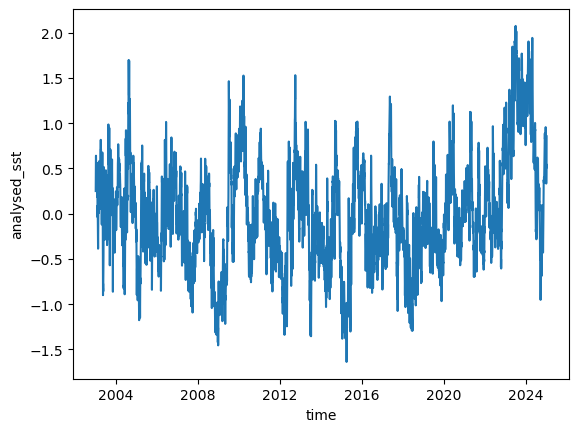

In [85]:
sst_anom_wmean.plot()

In [86]:
## Save in netcdf
sst_wmean.to_netcdf(dataDir+'/sstdMUR_mean_'+titulo_short+'.nc',mode='w')   
sst_anom_wmean.to_netcdf(dataDir+'/sstdMUR_anom_mean_'+titulo_short+'.nc',mode='w')

In [87]:
if titulo_short=='GO' or titulo_short=='NAtl' or titulo_short=='LEB' or titulo_short=='CAN' or titulo_short=='NOR' or titulo_short=='SUD' or titulo_short=='ESA' or titulo_short=='IBICan':
        sst_anom_LD=sst_anom[-1,:,:]
        sst_anom_LD.to_netcdf(dataDir+'/sstLDMUR_anom_'+titulo_short+'.nc',mode='w')

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 10.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


# Monthly analisis

In [88]:
sst

<xarray.DataArray 'analysed_sst' (time: 8036, lat: 851, lon: 1501)> Size: 82GB
dask.array<rechunk-merge, shape=(8036, 851, 1501), dtype=float64, chunksize=(1, 851, 1501), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
  * lat      (lat) float32 3kB 24.0 24.01 24.02 24.03 ... 32.47 32.48 32.49 32.5
  * lon      (lon) float32 6kB -25.0 -24.99 -24.98 ... -10.02 -10.01 -10.0

In [89]:
sst = sst.resample(time='ME').mean(dim='time',skipna=True).compute()

/opt/conda/envs/ocean/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 15.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [90]:
## Calculate global mean weigthtened
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()
    

In [91]:
## Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [92]:
## Create anomaly
print('    > Compute anomaly mean')
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.load();

    > Compute anomaly mean


In [93]:
##Calculate global mean weigthtened
print('    > Compute weigthtened mean')
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=12,center=True).mean()

    > Compute weigthtened mean


In [94]:
##Save in netcdf
print('    > to netcdf')
sst_anom.to_netcdf(dataDir+'/sstmMUR_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir+'/sstmMUR_mean_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir+'/sstmMUR_anom_mean_'+titulo_short+'.nc',mode='w')

    > to netcdf
